In [141]:
# !pip install opencv-python pydotplus six graphviz

In [142]:
# importamos las librerias necesarias
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np 
# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [143]:
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

In [144]:
def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]


In [145]:
DATA_PATH = "../data/union/End"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_final.csv")
    return pd.read_csv(csv_path)

In [146]:
df = load_data_prep()

In [147]:
# Variable a predecir
target = 'label'

# Construcción de la matriz de features
X = df.drop(['cod', 'label'], axis=1)

# Construcción del vector a predecir
y = df[target].values

print('Dimensión de la matriz de features: {}'.format(X.shape))
print('Dimensión del vector a predecir: {}'.format(y.shape))
print('Vector a predecir: {}'.format(y))

Dimensión de la matriz de features: (67, 290)
Dimensión del vector a predecir: (67,)
Vector a predecir: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [148]:
# Solo por esta vez para a fijar la semilla de numeros aleatorios
# para que se separe siempre igual cada vez que corramos esta notebook 
random_seed = 123475

# Creacion de las matrices de entrenamiento y testeo. Aca fijamos la semilla para que siempre separe igual
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = random_seed)

print('Dimensión de la matriz de features para entrenamiento: {}'.format(X_train.shape))
print('Dimensión de la matriz de features para testeo: {}'.format(X_test.shape))

Dimensión de la matriz de features para entrenamiento: (60, 290)
Dimensión de la matriz de features para testeo: (7, 290)


In [149]:
# Ajustamos el estandarizador
std_scale.fit(X_test)
std_scale.fit(X_train)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_test_scaled = std_scale.transform(X_test)
X_scaled = std_scale.transform(X_train)

In [150]:
componentes = 3 # puede ser None o un número entero o un float entre 0 y 1 que representa la varianza acumulada que se quiere explicar

In [151]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# instanciemos el modelo y entremoslo en el conjunto de autos
arbol = DecisionTreeClassifier(criterion='gini', max_depth=componentes, min_samples_leaf=1, min_samples_split=2, ccp_alpha=0)
arbol.fit(X_scaled,y_train)
accuracy_score(y_train, arbol.predict(X_scaled))

0.9833333333333333

In [152]:
# veamos que tan bien le fue a este modelo
y_test = y_test.astype(y_train.dtype)
print(classification_report(y_true=y_test,y_pred=arbol.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.75      0.60         4

    accuracy                           0.43         7
   macro avg       0.25      0.38      0.30         7
weighted avg       0.29      0.43      0.34         7



In [153]:
cm = confusion_matrix(y_test, arbol.predict(X_test_scaled)) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4)))

Matriz de confusion del modelo es:
[[0 3]
 [1 3]]
Sensibilidad del modelo es de: 0.5
Especificidad del modelo es de: 0.0
BA del modelo es de: 0.25


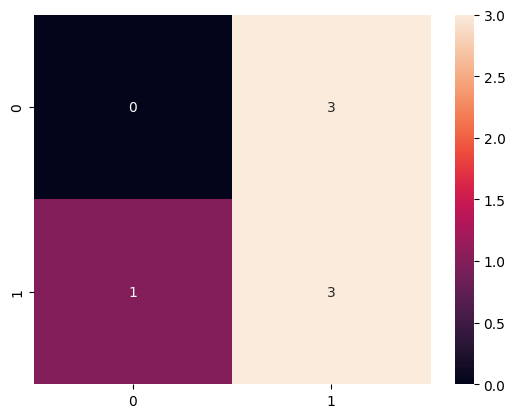

In [154]:
cf_matrix = confusion_matrix(y_test, arbol.predict(X_test_scaled))
sns.heatmap(cf_matrix, annot=True);

## Feature importance

Los árboles nos permiten definir una manera de medir la importancia de los features (o *Feature Importances*) basado en la ganancia de información obtenida cada vez que se utilizo cada feature para hacer un split. Para esto, una vez entrando el árbol, el método que utilizaremos es: 

```
# arbol.feature_importances_
```

In [155]:
# calculando las 5 feature importances mas altas
importances = pd.Series(arbol.feature_importances_).sort_values(ascending=False)[:10]
importances

230    0.264878
85     0.233739
236    0.189068
258    0.176586
104    0.074137
245    0.061591
186    0.000000
192    0.000000
196    0.000000
195    0.000000
dtype: float64

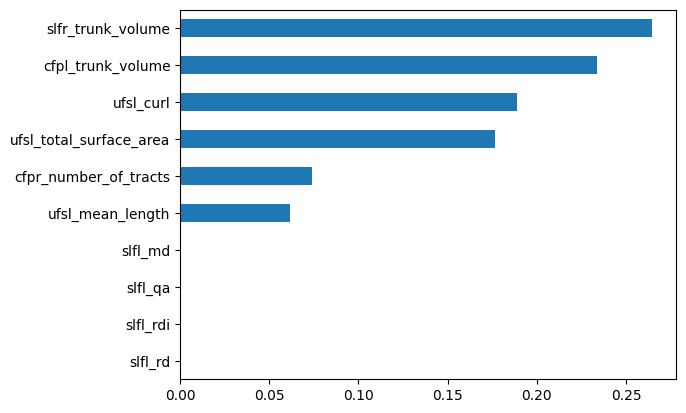

In [156]:
f5_names = list(pd.Series(X_test.columns)[importances.index.to_list()])
fig, ax = plt.subplots()
importances.plot.barh(ax=ax)
ax.set_yticklabels(f5_names)
ax.invert_yaxis()

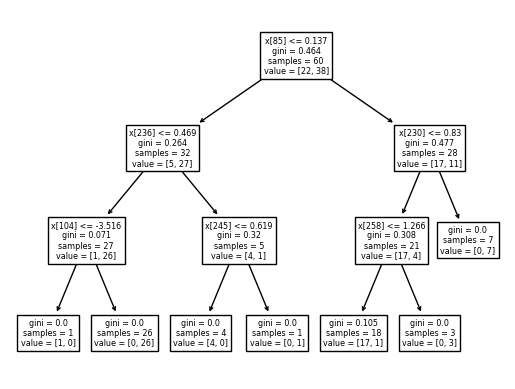

In [157]:
plot_tree(arbol);


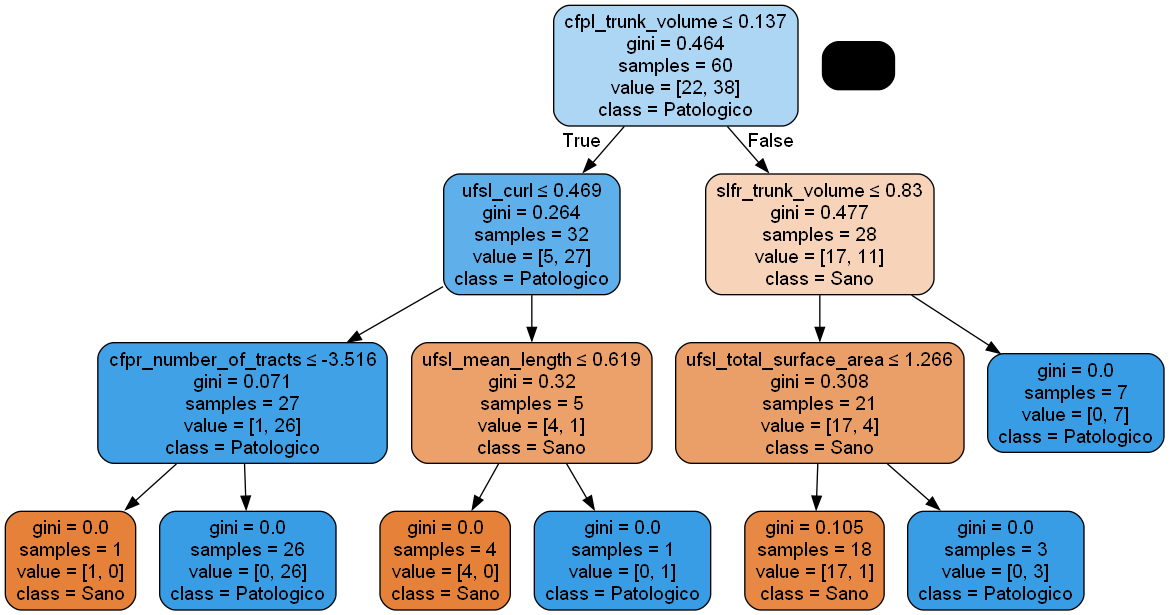

In [158]:
# libreria
#from sklearn.externals.six import StringIO 
from six import StringIO 
from IPython.display import Image 
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data,
                feature_names=X_train.columns,
                class_names=["Sano","Patologico"],  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Overfitting: profundidad del árbol y post-pruning

Dado que los árboles son modelos que tienden a overfittear tenemos que recurrir a distintas técnicas para mitigar este problema. Veamos primero el efecto de la profundidad del árbol en el trade-off sesgo varianza.

In [159]:
profundidad = list(range(1,20))
resultados_train = []
resultados_test  = []

for depth in profundidad:
    # instanciamos el modelo uniforme
    arbol = DecisionTreeClassifier(criterion='gini', max_depth=depth, min_samples_leaf=1, min_samples_split=2, ccp_alpha=0, class_weight="balanced")
    arbol.fit(X_scaled, y_train)
    y_train_pred = arbol.predict(X_scaled)
    y_pred = arbol.predict(X_test_scaled)
    resultados_train.append(accuracy_score(y_train, y_train_pred))
    resultados_test.append(accuracy_score(y_test, y_pred))

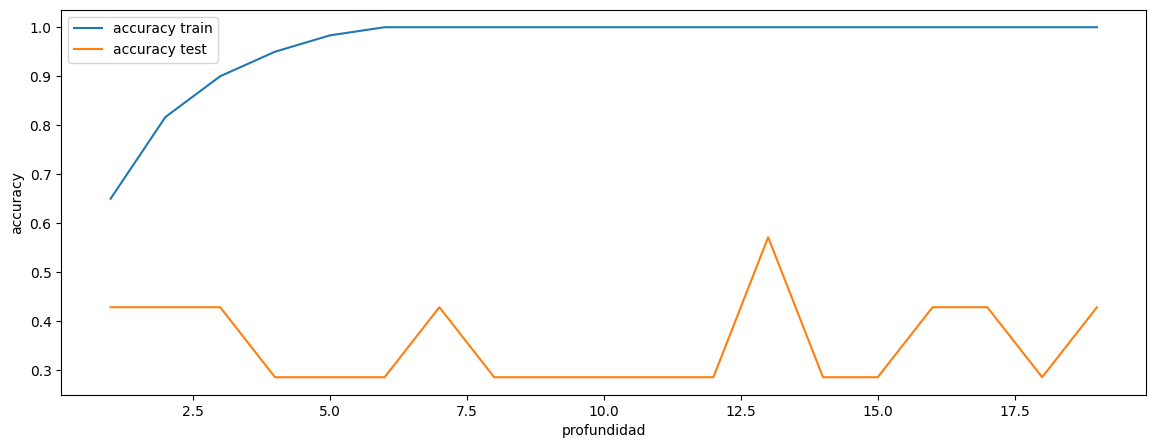

In [160]:
# veamos que paso en cada caso
f, ax = plt.subplots(1,1,figsize=(14,5),sharey=True)
ax.plot(profundidad, resultados_train, profundidad, resultados_test);
ax.legend(['accuracy train', 'accuracy test']);
ax.set(xlabel='profundidad',ylabel='accuracy');

In [161]:
# veamos que pasa con un árbol sin corte de profundidad
arbol = DecisionTreeClassifier(criterion='gini', ccp_alpha=0)
arbol.fit(X_scaled, y_train)
#print(classification_report(y_true=y_test,y_pred=arbol.predict(X_test)))
print('Accuracy en entrenamiento: %f' % accuracy_score(y_train,arbol.predict(X_scaled)))
print('Accuracy en test: %f' % accuracy_score(y_test,arbol.predict(X_test_scaled)))

Accuracy en entrenamiento: 1.000000
Accuracy en test: 0.428571


In [162]:
cm = confusion_matrix(y_test, arbol.predict(X_test_scaled)) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4)))

Matriz de confusion del modelo es:
[[0 3]
 [1 3]]
Sensibilidad del modelo es de: 0.5
Especificidad del modelo es de: 0.0
BA del modelo es de: 0.25


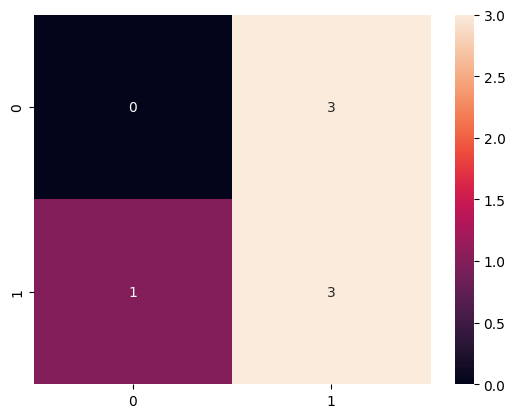

In [163]:
cf_matrix = confusion_matrix(y_test, arbol.predict(X_test_scaled))
sns.heatmap(cf_matrix, annot=True);

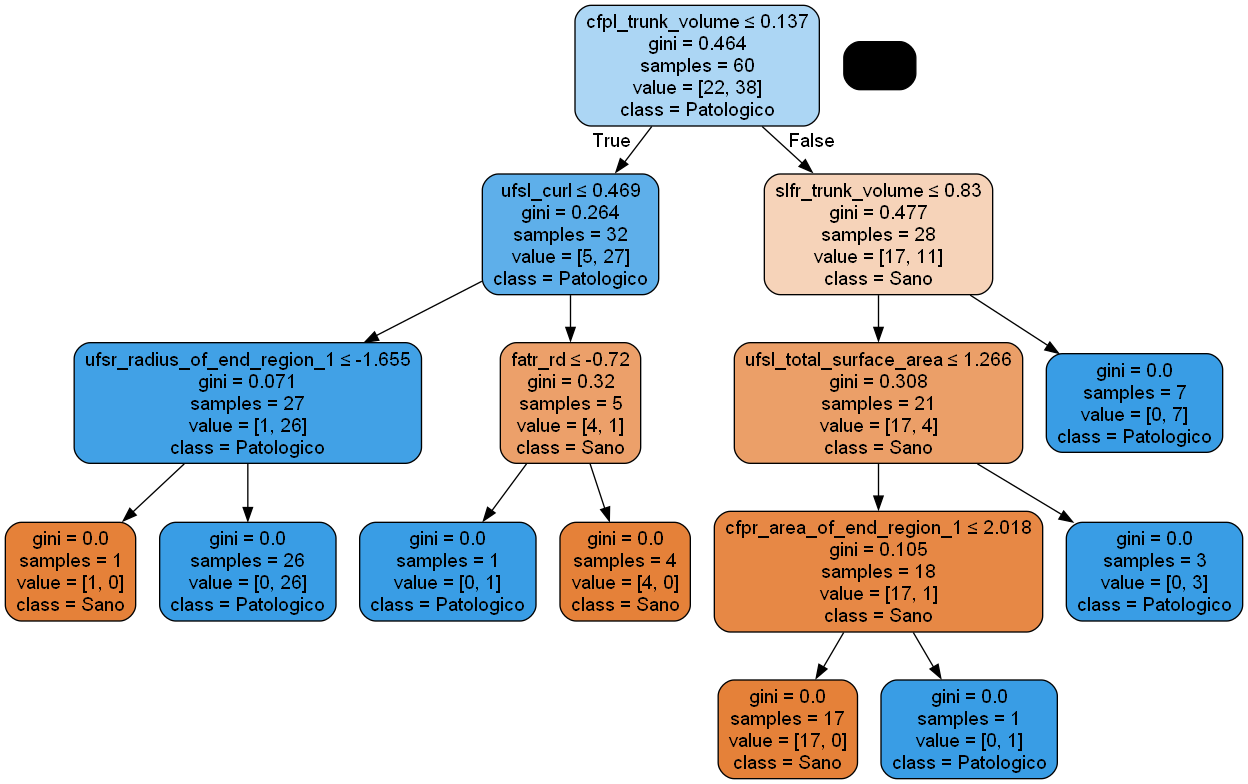

In [164]:
# grafiquemos este árbol
dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data,
                feature_names=X_train.columns,
                class_names=["Sano","Patologico"],    
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Una técnica que nos permite mitigar el overfitting es lo que se conoce como post-prunning. El objetivo de esta técnica es *podar* el árbol entrenado, penalizando de alguna forma los árboles más complejos. El algortimo de poda que tenemos implementado en Scikit-Learn es el [Minimal Cost-Complexity Pruning](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning). El hiperparámetro que controla esta penalización es ccp_alpha $\geq 0$, cuando este hiperparámetro es 0, no realizamos ningún tipo de poda, y a medida que aumentamos dicho hiperparámetro penalizaremos más fuertemente la cantidad de nodos terminales del árbol.

In [165]:
arbol = DecisionTreeClassifier(criterion='gini', ccp_alpha=0.08)
arbol.fit(X_scaled, y_train)
#print(classification_report(y_true=y_test,y_pred=arbol.predict(X_test)))
print('Accuracy en entrenamiento: %f' % accuracy_score(y_train,arbol.predict(X_scaled)))
print('Accuracy en test: %f' % accuracy_score(y_test,arbol.predict(X_test_scaled)))

Accuracy en entrenamiento: 0.900000
Accuracy en test: 0.571429


In [166]:
cm = confusion_matrix(y_test, arbol.predict(X_test_scaled)) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4)))

Matriz de confusion del modelo es:
[[1 2]
 [1 3]]
Sensibilidad del modelo es de: 0.6
Especificidad del modelo es de: 0.5
BA del modelo es de: 0.55


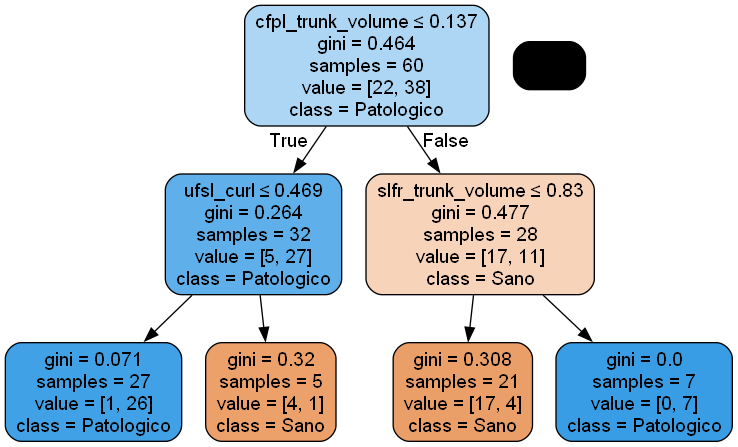

In [167]:
dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data, 
                feature_names=X_train.columns,
                class_names=["Sano","Patologico"],   
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [168]:
# veamos que tan bien le fue a este modelo
y_test = y_test.astype(y_train.dtype)
print(classification_report(y_true=y_test,y_pred=arbol.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.60      0.75      0.67         4

    accuracy                           0.57         7
   macro avg       0.55      0.54      0.53         7
weighted avg       0.56      0.57      0.55         7



In [169]:
cm = confusion_matrix(y_test, arbol.predict(X_test_scaled)) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4)))

Matriz de confusion del modelo es:
[[1 2]
 [1 3]]
Sensibilidad del modelo es de: 0.6
Especificidad del modelo es de: 0.5
BA del modelo es de: 0.55


In [170]:
#print(classification_report(y_true=y_test,y_pred=arbol.predict(X_test)))
print('Accuracy en entrenamiento: %f' % accuracy_score(y_train,arbol.predict(X_scaled)))
print('Accuracy en test: %f' % accuracy_score(y_test,arbol.predict(X_test_scaled)))

Accuracy en entrenamiento: 0.900000
Accuracy en test: 0.571429


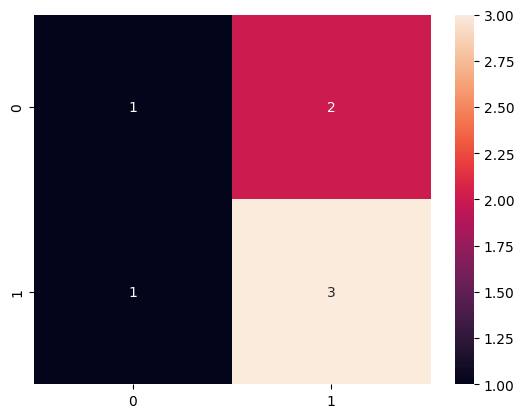

In [171]:
cf_matrix = confusion_matrix(y_test, arbol.predict(X_test_scaled))
sns.heatmap(cf_matrix, annot=True);

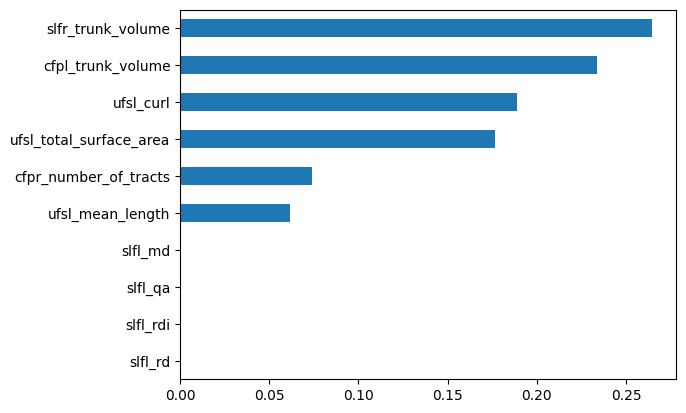

In [172]:
f5_names = list(pd.Series(X_test.columns)[importances.index.to_list()])
fig, ax = plt.subplots()
importances.plot.barh(ax=ax)
ax.set_yticklabels(f5_names)
ax.invert_yaxis()

In [173]:
# veamos como afecta el rendimiento y la profundidad del árbol
ccp_alpha_vals = np.arange(0,1,0.05)
resultados_train = []
resultados_test  = []
profundidad      = []

for ccp in ccp_alpha_vals:
    # instanciamos el modelo uniforme
    arbol = DecisionTreeClassifier(criterion='gini', ccp_alpha=ccp)
    arbol.fit(X_scaled, y_train)
    # guardamos la profundidad del árbol
    profundidad.append(arbol.tree_.max_depth)
    y_train_pred = arbol.predict(X_scaled)
    y_pred = arbol.predict(X_test_scaled)
    resultados_train.append(accuracy_score(y_train, y_train_pred))
    resultados_test.append(accuracy_score(y_test, y_pred))

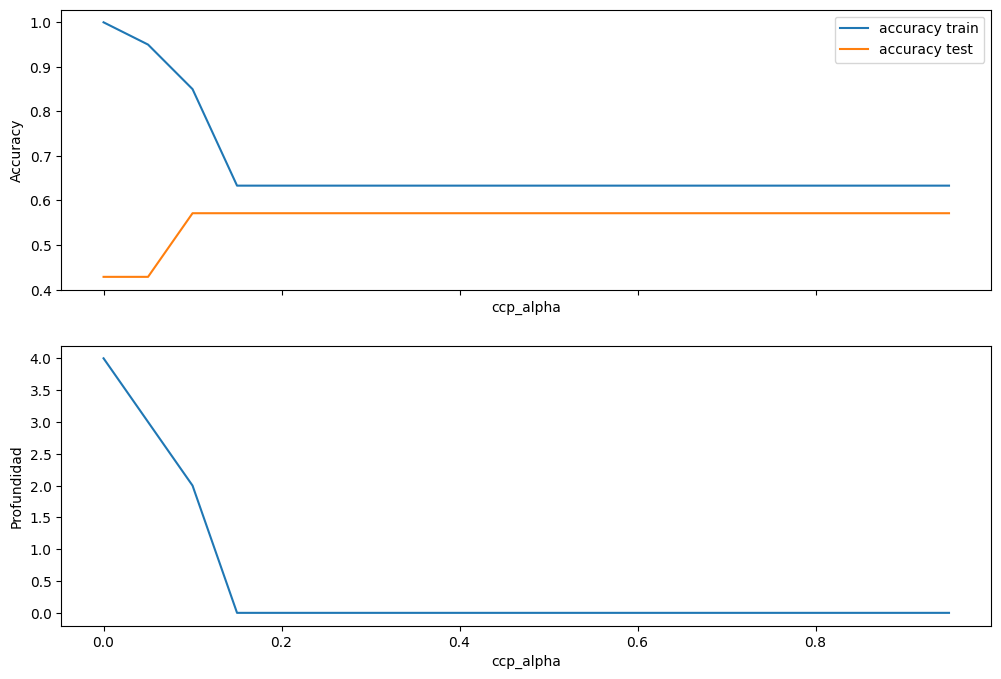

In [174]:
f,ax = plt.subplots(2,1,figsize=(12,8),sharex=True)
ax[0].plot(ccp_alpha_vals, resultados_train, ccp_alpha_vals, resultados_test);
ax[0].legend(['accuracy train', 'accuracy test']);
ax[0].set(xlabel='ccp_alpha',ylabel='Accuracy');
ax[1].plot(ccp_alpha_vals, profundidad)
ax[1].set(xlabel='ccp_alpha',ylabel='Profundidad');

In [175]:
ccp_alpha_vals

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [176]:
arbol = DecisionTreeClassifier(criterion='gini', ccp_alpha=0.15)
arbol.fit(X_scaled, y_train)
#print(classification_report(y_true=y_test,y_pred=arbol.predict(X_test)))
print('Accuracy en entrenamiento: %f' % accuracy_score(y_train,arbol.predict(X_scaled)))
print('Accuracy en test: %f' % accuracy_score(y_test,arbol.predict(X_test_scaled)))

Accuracy en entrenamiento: 0.633333
Accuracy en test: 0.571429


In [177]:
cm = confusion_matrix(y_test, arbol.predict(X_test_scaled)) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4)))

Matriz de confusion del modelo es:
[[0 3]
 [0 4]]
Sensibilidad del modelo es de: 0.5714
Especificidad del modelo es de: nan
BA del modelo es de: nan


C:\Users\User\AppData\Local\Temp\ipykernel_8276\3012757591.py:3: RuntimeWarning: invalid value encountered in scalar divide
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])


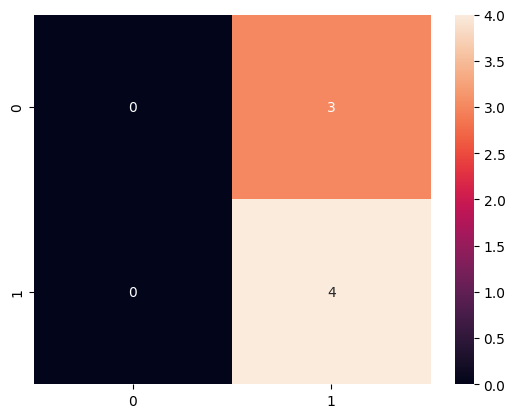

In [178]:
cf_matrix = confusion_matrix(y_test, arbol.predict(X_test_scaled))
sns.heatmap(cf_matrix, annot=True);

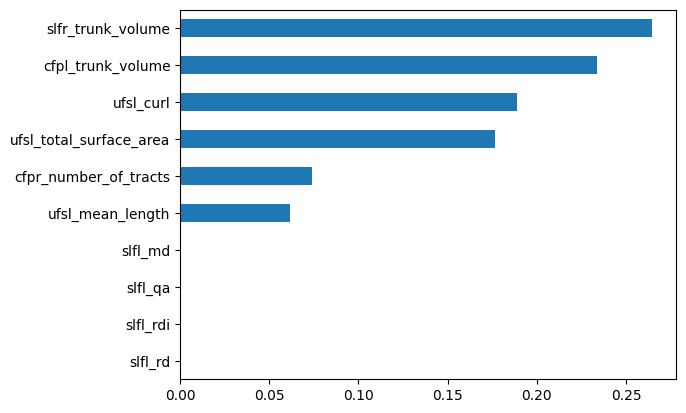

In [179]:
f5_names = list(pd.Series(X_test.columns)[importances.index.to_list()])
fig, ax = plt.subplots()
importances.plot.barh(ax=ax)
ax.set_yticklabels(f5_names)
ax.invert_yaxis()